In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import copy
import re
import openpyxl
import seaborn as sns
import seaborn.objects as so
import heapq

In [5]:
class Astar():
    def __init__(self, path, start, goal, map_range, max_margin, map_sheet='Sheet1', dis_table_sheet='Sheet2') -> None:
        self.file_path = path
        self.map_sheet = map_sheet
        self.dis_table_sheet = dis_table_sheet
        self.map_range = map_range
        self.max_margin = max_margin
        self.map = None
        self.dis_table = None
        self.result_demo = np.ones((self.max_margin, self.max_margin, 3))
        self.action_space = {0: [-1, 0],   # up
                           1: [1, 0],      # down
                           2: [0, 1],      # right
                           3: [0, -1],     # left
                           4: [-1, 1],     # upper right
                           5: [-1, -1],    # upper left
                           6: [1, 1],      # lower right
                           7: [1, -1]}     # lower left

        self.start_node = start
        self.target_node = goal
        self.cur_node = self.start_node
        self.pre_node = None

        # For A* algorithm
        self.open_set = []    # Priority queue using heapq
        self.closed_set = set()  # Set of visited nodes
        self.g_score = {}     # Cost from start to current node
        self.f_score = {}     # g_score + heuristic
        self.came_from = {}   # Parent map for path reconstruction

        # For visualization
        self.open_queue = {}  # Nodes explored but not in path
        self.close_queue = {} # Nodes in the final path

    def generate_map(self):
        wb = openpyxl.load_workbook(self.file_path)
        ws = wb[self.map_sheet]
        _range = self.map_range
        map_data = []
        for row in ws[_range]:
            map_row = []
            for cell in row:
                map_row.append(cell.value)
            map_data.append(map_row)
        map_data = np.array(map_data)
        self.map = map_data

    def generate_dis_table(self):
        wb = openpyxl.load_workbook(self.file_path)
        ws = wb[self.dis_table_sheet]
        _range = self.map_range
        dis_table = []
        for row in ws[_range]:
            dis_table_row = []
            for cell in row:
                dis_table_row.append(cell.value)
            dis_table.append(dis_table_row)
        dis_table = np.array(dis_table)
        self.dis_table = dis_table

    def heuristic(self, node):
        # Euclidean distance
        return math.sqrt((node[0] - self.target_node[0])**2 + (node[1] - self.target_node[1])**2)

    def get_neighbors(self, node):
        neighbors = []
        for action in range(8):  # 8 actions
            nx = node[0] + self.action_space[action][0]
            ny = node[1] + self.action_space[action][1]

            # Check if in bounds
            if 0 <= nx < self.max_margin and 0 <= ny < self.max_margin:
                # Check if not obstacle (using dis_table, where 1024 means obstacle)
                if abs(self.dis_table[nx][ny]) != 1024:
                    neighbors.append([nx, ny])
        return neighbors

    def reconstruct_path(self):
        # Reconstruct the path from target to start
        current = tuple(self.target_node)
        path = {}

        while current in self.came_from:
            path[str(list(current))] = list(self.came_from[current])
            current = self.came_from[current]

        # For visualization compatibility
        self.close_queue = path
        return path

    def run_astar(self):
        start_tuple = tuple(self.start_node)
        target_tuple = tuple(self.target_node)

        self.g_score[start_tuple] = 0
        self.f_score[start_tuple] = self.heuristic(self.start_node)
        heapq.heappush(self.open_set, (self.f_score[start_tuple], start_tuple))

        # Đánh dấu các điểm đã xét (dù chưa chắc thuộc đường đi)
        self.open_queue[start_tuple] = True

        while self.open_set:
            current_f, current = heapq.heappop(self.open_set)
            current_list = list(current)

            # Nếu đã đến đích
            if current == target_tuple:
                self.reconstruct_path()
                return True

            # Thêm vào closed set và lưu lại để vẽ
            self.closed_set.add(current)
            self.close_queue[str(current_list)] = current_list  # Lưu để hiển thị

            for neighbor in self.get_neighbors(current_list):
                neighbor_tuple = tuple(neighbor)

                if neighbor_tuple in self.closed_set:
                    continue

                tentative_g = self.g_score[current] + math.sqrt(
                    (neighbor[0] - current_list[0])**2 +
                    (neighbor[1] - current_list[1])**2
                )

                if neighbor_tuple not in self.g_score or tentative_g < self.g_score[neighbor_tuple]:
                    self.came_from[neighbor_tuple] = current
                    self.g_score[neighbor_tuple] = tentative_g
                    self.f_score[neighbor_tuple] = tentative_g + self.heuristic(neighbor)

                    heapq.heappush(self.open_set, (self.f_score[neighbor_tuple], neighbor_tuple))

                    # Lưu vào open_queue để vẽ
                    self.open_queue[neighbor_tuple] = True

        return False


In [ ]:
map_name = 'Aisle'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 30]
goal = [12, 19]
map_range = 'A1:AF32'
max_margin = 32
#env_discription = "Obstacles: This map mainly includes two obstacles respectively located at region A and B. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:22], j: [13:18]; Region B: i: [26:31], j: [13:18]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "

env = Astar(path, start, goal, map_range, max_margin)

In [ ]:
map_name = 'Canyon'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [3, 23]
goal = [21, 1]
map_range = 'A1:AF32'
max_margin = 32
#env_discription = "Obstacles: This map mainly includes four obstacles respectively located at region A, B, C and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:15], j: [0:21]; Region B: i: [0:15], j: [25:31]; C: i: [22:31], j: [0:6]; Region D: i: [22:31], j: [10:31]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "

env = Astar(path, start, goal, map_range, max_margin)

In [ ]:
map_name = 'Double_door'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 29]
goal = [28, 1]
map_range = 'A1:AF32'
max_margin = 32
#env_discription = "Obstacles: This map includes four obstacles respectively located at region A, B, C, and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:26], j: [0:10]; Region B: i: [0:20], j: [11:21]; Region C: i: [30:31], j: [10:21]; Region D: i: [23:31], j: [21:31] except the grid i=23 and j=21. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "

env = Astar(path, start, goal, map_range, max_margin)

In [ ]:
map_name = 'Aisle_24'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 22]
goal = [21, 2]
map_range = 'A1:X24'
max_margin = 24
#env_discription = "Obstacles: This map mainly includes two obstacles respectively located at region A and B. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:15], j: [9:13]; Region B: i: [19:23], j: [9:13]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt."
env = Astar(path, start, goal, map_range, max_margin)

In [ ]:
map_name = 'Canyon_24'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [2, 17]
goal = [15, 2]
map_range = 'A1:X24'
max_margin = 24
#env_discription = "Obstacles: This map mainly includes four obstacles respectively located at region A, B, C and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:11], j: [0:15]; Region B: i: [0:11], j: [19:23]; C: i: [16:23], j: [0:4]; Region D: i: [16:23], j: [8:23]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
env = Astar(path, start, goal, map_range, max_margin)

In [ ]:
map_name = 'Double_door_24'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 22]
goal = [19, 1]
map_range = 'A1:X24'
max_margin = 24
#env_discription = "Obstacles: This map includes four obstacles respectively located at region A, B, C, and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:17], j: [0:7]; Region B: i: [0:15], j: [8:16]; Region C: i: [21:23], j: [7:15]; Region D: i: [18:23], j: [16:23] except the region where i=18 and j=16. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
env = Astar(path, start, goal, map_range, max_margin)

In [6]:
map_name = 'Aisle_16'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 13]
goal = [14, 1]
#env_discription = "Obstacles: This map mainly includes two obstacles respectively located at region A and B. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:8], j: [7:9]; Region B: i: [12:15], j: [7:9]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt."
map_range ='A1:P16'
max_margin = 16
env = Astar(path, start, goal, map_range, max_margin)

In [ ]:
map_name = 'Canyon_16'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [2, 10]
goal = [11, 1]
env_discription = "Obstacles: This map mainly includes four obstacles respectively located at region A, B, C and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:8], j: [0:9]; Region B: i: [0:8], j: [12:15]; C: i: [12:15], j: [0:3]; Region D: i: [12:15], j: [6:15]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
map_range ='A1:P16'
max_margin = 16
env = Astar(path, start, goal, map_range, max_margin)

In [ ]:
map_name = 'Double_door_16'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 15]
goal = [14, 1]
#env_discription = "Obstacles: This map includes four obstacles respectively located at region A, B, C, and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:12], j: [0:4]; Region B: i: [0:10], j: [5:10]; Region C: i=15, j: [5:9]; Region D: i: [13:15], j: [10:15] except the grid i=13 and j=10. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
map_range ='A1:P16'
max_margin = 16
env = Astar(path, start, goal, map_range, max_margin)

In [7]:
env.generate_map()
env.generate_dis_table()
env.generate_dis_table()


In [8]:
def generate_traj_map(map_data, env, my_love_path, my_love_search, start, goal):
    map1 = copy.deepcopy(map_data)
    map2 = copy.deepcopy(map1)
    map_rgb = np.dstack((map_data, map1, map2)).astype(float)

    # Color the searched space (xanh lá)
    for node_tuple in my_love_search:
        x, y = node_tuple
        map_rgb[x][y][0] = 0.0  # Red
        map_rgb[x][y][1] = 1.0  # Green
        map_rgb[x][y][2] = 0.0  # Blue

    # Color nodes in the path (xanh lá - sẽ ghi đè bằng đỏ sau)
    for key in my_love_path:
        x, y = my_love_path[key]
        map_rgb[x][y][0] = 0.0
        map_rgb[x][y][1] = 1.0
        map_rgb[x][y][2] = 0.0

    # Trace back the path
    cur = goal
    parent = my_love_path[str(cur)] if str(cur) in my_love_path else None
    x_axis = [goal[0]]
    y_axis = [goal[1]]
    bas_dir_vector = np.array([0.0, 1.0])
    dis_vector = np.array(goal) - np.array(start)
    sum_angle = 0.0
    avg_angle = 0.0
    count = 0
    max_times = 0

    # Calculate path metrics
    while parent is not None and parent != start:
        count += 1
        x_axis.append(parent[0])
        y_axis.append(parent[1])
        my_love_path.pop(str(cur))

        dir_vector = np.array(cur) - np.array(parent)
        angle = abs(np.arccos(np.clip(np.dot(dir_vector, bas_dir_vector) /
                         (np.linalg.norm(dir_vector) * np.linalg.norm(bas_dir_vector)), -1.0, 1.0)))
        dis_angle = abs(np.arccos(np.clip(np.dot(dir_vector, dis_vector) /
                              (np.linalg.norm(dir_vector) * np.linalg.norm(dis_vector)), -1.0, 1.0)))

        angle = round(angle, 3)
        dis_angle = round(dis_angle, 3)

        sum_angle += angle
        avg_angle = round(sum_angle / float(count), 2) if count > 0 else 0

        if dis_angle > math.pi / 2.0:
            max_times += 1

        cur = parent
        if str(cur) in my_love_path:
            parent = my_love_path[str(cur)]
        else:
            parent = None
        bas_dir_vector = dir_vector

    # Add start
    x_axis.append(start[0])
    y_axis.append(start[1])

    return map_rgb, x_axis, y_axis, avg_angle, max_times


def color_path(map_rgb, x_axis, y_axis):
    color_0 = 1.0  # Red
    color_2 = 0.0  # Blue
    delta_color = 1.0 / float(len(x_axis)) if len(x_axis) > 0 else 0

    for i in range(len(x_axis)):
        x = x_axis[i]
        y = y_axis[i]
        map_rgb[x][y][0] = color_0
        map_rgb[x][y][1] = 0.0
        map_rgb[x][y][2] = color_2

        color_0 -= delta_color
        color_2 += delta_color

    traj_map = (map_rgb * 255.0).astype(int)

    return traj_map, len(x_axis)



[[  -15   -14   -15   -16   -17   -18   -19 -1024 -1024 -1024   -23   -24
    -25   -26   -27   -28]
 [  -14   -13   -14   -15   -16   -17   -18 -1024 -1024 -1024   -22   -23
    -24   -25   -26   -27]
 [  -13   -12   -13   -14   -15   -16   -17 -1024 -1024 -1024   -21   -22
    -23   -24   -25   -26]
 [  -12   -11   -12   -13   -14   -15   -16 -1024 -1024 -1024   -20   -21
    -22   -23   -24   -25]
 [  -11   -10   -11   -12   -13   -14   -15 -1024 -1024 -1024   -19   -20
    -21   -22   -23   -24]
 [  -10    -9   -10   -11   -12   -13   -14 -1024 -1024 -1024   -18   -19
    -20   -21   -22   -23]
 [   -9    -8    -9   -10   -11   -12   -13 -1024 -1024 -1024   -17   -18
    -19   -20   -21   -22]
 [   -8    -7    -8    -9   -10   -11   -12 -1024 -1024 -1024   -16   -17
    -18   -19   -20   -21]
 [   -7    -6    -7    -8    -9   -10   -11 -1024 -1024 -1024   -15   -16
    -17   -18   -19   -20]
 [   -6    -5    -6    -7    -8    -9   -10   -11   -12   -13   -14   -15
    -16   -17   -

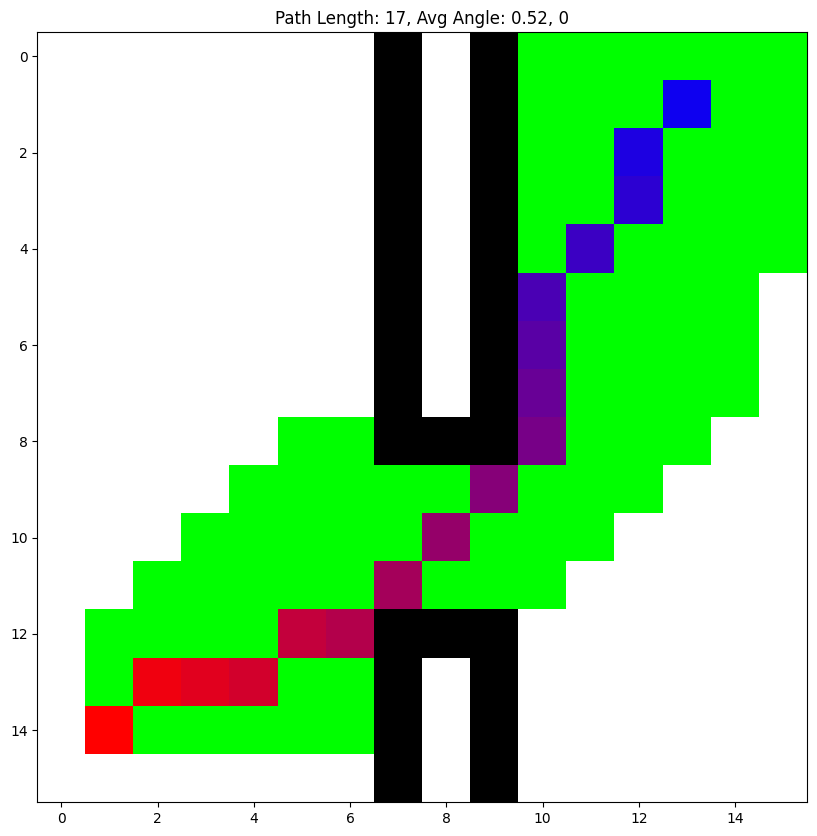

In [9]:
found_path = env.run_astar()
print(env.dis_table)

if found_path:
    # Create visualization
    my_love_path = copy.deepcopy(env.close_queue)
    my_love_search = copy.deepcopy(env.open_queue)

    # Generate trajectory map
    traj_map, x_axis, y_axis, avg_angle, max_times = generate_traj_map(
        env.map, env, my_love_path, my_love_search, env.start_node, env.target_node
    )

    # Color the path
    colored_map, path_length = color_path(traj_map, x_axis, y_axis)

    # Display result
    plt.figure(figsize=(10, 10))
    plt.imshow(colored_map)
    plt.title(f"Path Length: {path_length}, Avg Angle: {avg_angle}, {max_times}")
    plt.show()
else:
    print("No path found!")

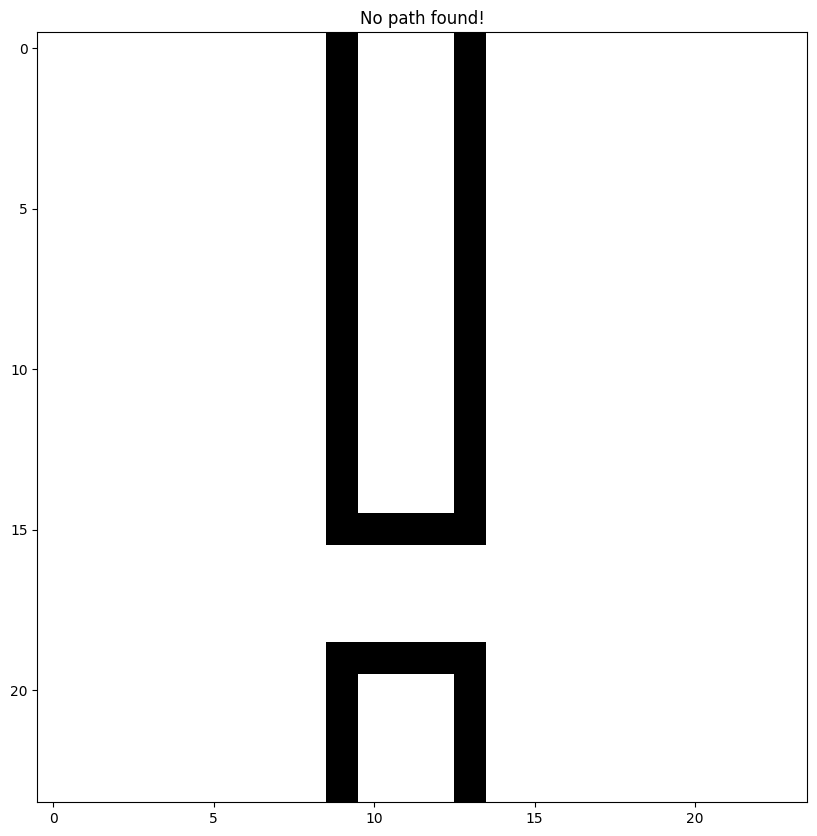

In [ ]:
found_path = env.run_astar()

# Tạo visualization (nếu tìm thấy đường)
my_love_path = copy.deepcopy(env.close_queue) if found_path else []
my_love_search = copy.deepcopy(env.open_queue) if found_path else []

# Tạo bản đồ (luôn thực hiện)
traj_map, x_axis, y_axis, avg_angle, max_times = generate_traj_map(
    env.map, env, my_love_path, my_love_search, env.start_node, env.target_node
)

# Nếu tìm thấy đường đi, tô màu đường đi
if found_path:
    colored_map, path_length = color_path(traj_map, x_axis, y_axis)
    title_text = f"Path Length: {path_length}, Avg Angle: {avg_angle}, {max_times}"
else:
    colored_map = traj_map  # Không có đường, chỉ hiển thị bản đồ gốc
    title_text = "No path found!"

# Hiển thị kết quả
plt.figure(figsize=(10, 10))
plt.imshow(colored_map)
plt.title(title_text)
plt.show()
